# Introduction To Machine Learning: linear classification
In this notebook, we shall use the usps dataset and differentiate between the grayscale digits 1 and 5

# Imports

In [1]:
# the warning wrapper is to avoid an annoying warning of h5py
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.linear_model import LinearRegression, LogisticRegression
#from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, roc_curve

### Load the usps dataset
Grayscale 16x16 digits.
already scaled to 0-1 range (instead of 0-255).

In [2]:
def hdf5(path, data_key = "data", target_key = "target", flatten = True):
    """
        loads data from hdf5:
        - hdf5 should have 'train' and 'test' groups
        - each group should have 'data' and 'target' dataset or spcify the key
        - flatten means to flatten images N * (C * H * W) as N * D array
    """
    with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_train = train.get(data_key)[:]
        y_train = train.get(target_key)[:]
        test = hf.get('test')
        X_test = test.get(data_key)[:]
        y_test = test.get(target_key)[:]
        if flatten:
            X_train = X_train.reshape(X_train.shape[0], reduce(lambda a, b: a * b, X_train.shape[1:]))
            X_test = X_test.reshape(X_test.shape[0], reduce(lambda a, b: a * b, X_test.shape[1:]))
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = hdf5("usps.h5")
print("Dataset loaded. Train shape: "+str(X_train.shape)+". Test shape: "+str(X_test.shape)+".")

Dataset loaded. Train shape: (7291, 256). Test shape: (2007, 256).


### View some samples

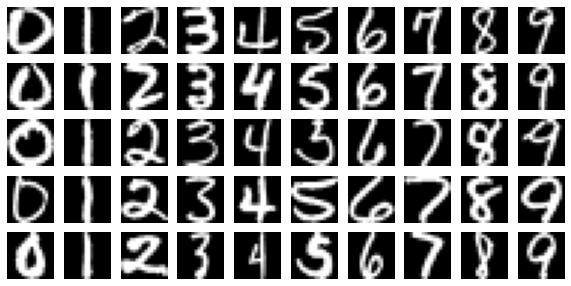

In [3]:
num_samples = 5
num_classes = len(set(y_train))

classes = set(y_train)
num_classes = len(classes)
fig, ax = plt.subplots(num_samples, num_classes, sharex = True, sharey = True, figsize=(num_classes, num_samples))

for label in range(num_classes):
    class_idxs = np.where(y_train == label)
    for i, idx in enumerate(np.random.randint(0, class_idxs[0].shape[0], num_samples)):
        # the imshow with 'gray' option, recieves either 0-255 integers, or 0-1 floats.
        ax[i, label].imshow(X_train[class_idxs[0][idx]].reshape([16, 16]), 'gray')
        ax[i, label].set_axis_off()
plt.show()

# Preprocessing
The input dimension is too big!

Regression models will use 257 weights (256 pixel + bias).
Lets reduce the input dimension to 2: Symmetry, and intensity.

In [4]:
def symmetry(image):
    im = image.reshape((16,16))
    return np.mean(1-np.abs(im - im[::-1,:]))
def intensity(image):
    return np.mean(image)
X_train_pro = np.array([np.array([intensity(im),symmetry(im)]) for im in X_train])

print('Done preprocessing. New shape: ', X_train_pro.shape)

Done preprocessing. New shape:  (7291, 2)


### Take only 5 and 1 digits

In [5]:
X_train_1, X_train_pro_1 = X_train[y_train == 1], X_train_pro[y_train == 1]
X_train_5, X_train_pro_5 = X_train[y_train == 5], X_train_pro[y_train == 5]

### Plot

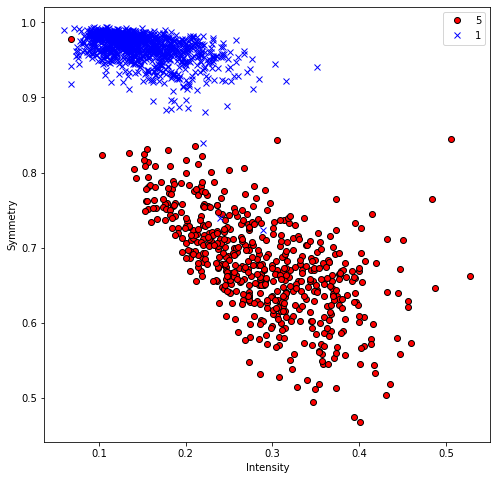

In [6]:
plt.figure(figsize=(8,8))
plt.plot([im[0] for im in X_train_pro_5],[im[1] for im in X_train_pro_5],'ro',label='5', markeredgecolor='black', markeredgewidth=1)
plt.plot([im[0] for im in X_train_pro_1],[im[1] for im in X_train_pro_1],'bx',label='1')
plt.xlabel('Intensity')
plt.ylabel('Symmetry')
plt.legend(numpoints=1)#handles=[red_dot, blue_x])
plt.show()

# Classification with linear regression

Intercept:  -5.853944
Coefficients:  [1.1142809 6.862549 ]


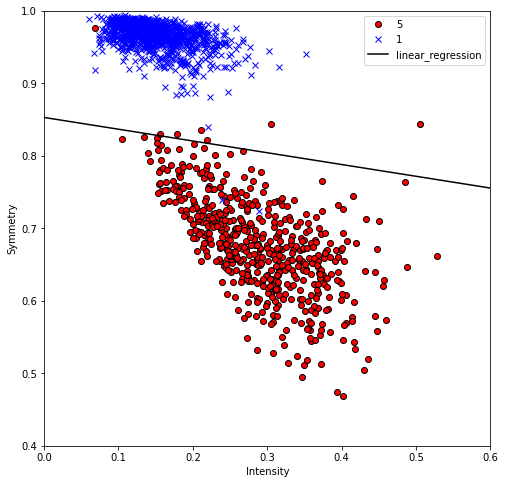

In [7]:
# set the dataset with 1 label for 1 and -1 for 5
X = np.concatenate([X_train_pro_1,X_train_pro_5])
y = np.ones(X.shape[0])
y[-X_train_pro_5.shape[0]:] = -1

# train
regr = LinearRegression().fit(X, y)
print('Intercept: ', regr.intercept_)
print('Coefficients: ', regr.coef_)

# plot
# we take 2 points where w_0+w_1x_1+w_2x_2 = 0. Once we nullify x_1 and once x_2
#(0,a), (b,0)
a,b = -regr.intercept_/regr.coef_[1], -regr.intercept_/regr.coef_[0]
plt.figure(figsize=(8,8))
plt.plot([im[0] for im in X_train_pro_5],[im[1] for im in X_train_pro_5],'ro',label='5', markeredgecolor='black', markeredgewidth=1)
plt.plot([im[0] for im in X_train_pro_1],[im[1] for im in X_train_pro_1],'bx',label='1')
plt.plot([0,b],[a,0],'black',label='linear_regression')
plt.ylim(0.4,1) # since there arent any sample with lower symmetry
plt.xlim(0,0.6) # since there arent any sample with higher Intensity
plt.xlabel('Intensity')
plt.ylabel('Symmetry')
plt.legend(numpoints=1)#handles=[red_dot, blue_x])
plt.show()

# Lets try with Logistic regression!

Intercept:  [-48.24042196]
Coefficients:  [ 1.85667894 56.44830475]


C:\Users\dor\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


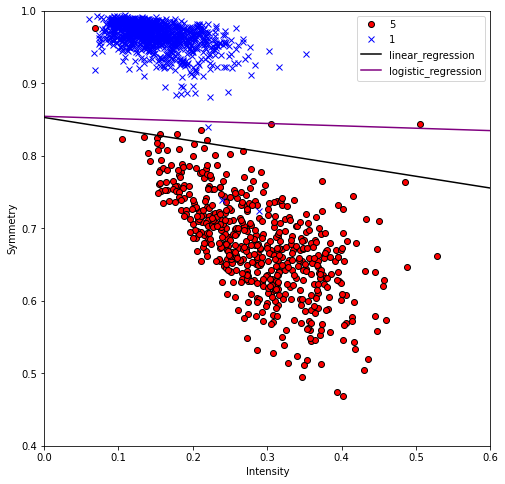

In [8]:
# set the dataset with 1 label for 1 and 0 for 5
X = np.concatenate([X_train_pro_1,X_train_pro_5])
y = np.ones(X.shape[0])
y[-X_train_pro_5.shape[0]:] = 0

# train
log_reg = LogisticRegression(C=1000).fit(X, y)
print('Intercept: ', log_reg.intercept_)
print('Coefficients: ', log_reg.coef_[0])

# plot
# we take 2 points where w_0+w_1x_1+w_2x_2 = 0. Once we nullify x_1 and once x_2
#(0,log_a), (log_b,0)
log_a,log_b = -log_reg.intercept_/log_reg.coef_[0][1], -log_reg.intercept_/log_reg.coef_[0][0]
plt.figure(figsize=(8,8))
plt.plot([im[0] for im in X_train_pro_5],[im[1] for im in X_train_pro_5],'ro',label='5', markeredgecolor='black', markeredgewidth=1)
plt.plot([im[0] for im in X_train_pro_1],[im[1] for im in X_train_pro_1],'bx',label='1')
plt.plot([0,b],[a,0],'black',label='linear_regression')
plt.plot([0,log_b],[log_a,0],'purple',label='logistic_regression')
plt.ylim(0.4,1) # since there arent any sample with lower symmetry
plt.xlim(0,0.6) # since there arent any sample with higher Intensity
plt.xlabel('Intensity')
plt.ylabel('Symmetry')
plt.legend(numpoints=1)#handles=[red_dot, blue_x])
plt.show()

### Using predicted probabilities

For classification tasks, the classifier have the predict_proba option which return a $N\times K$ array. Each sample with its corresponding probability for each class

In [ ]:
np.set_printoptions(suppress=True) # to remove the 'e' notation

In [21]:
log_reg.predict_proba(X)

array([[0.00116239, 0.99883761],
       [0.00161282, 0.99838718],
       [0.00062459, 0.99937541],
       ...,
       [0.99999572, 0.00000428],
       [0.99952762, 0.00047238],
       [0.99968827, 0.00031173]])

# How will our roc-curve and auc be for this case?

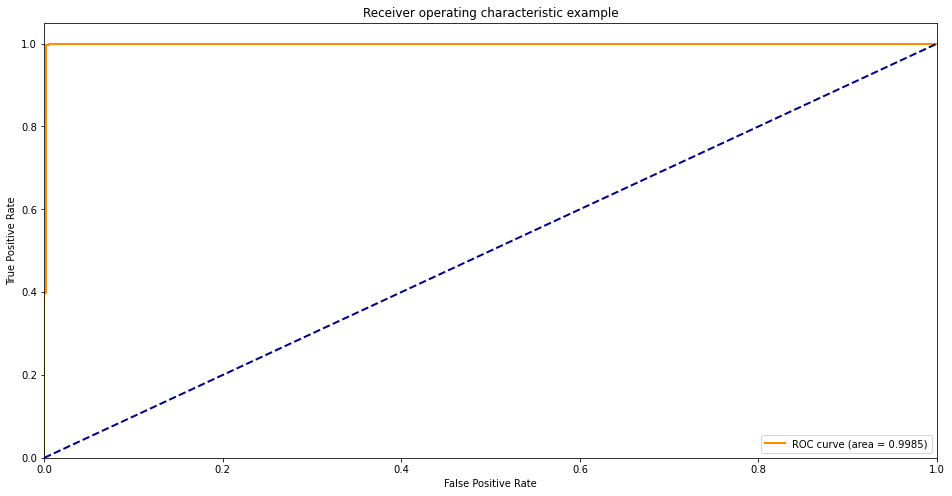

In [30]:
#compute values
fpr, tpr, thresholds = roc_curve(y, log_reg.predict_proba(X)[:,1])
auc = roc_auc_score(y, log_reg.predict_proba(X)[:,1])

#plot
plt.figure(figsize=(16,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()